# PHSC 213 Lab 2: Wave Superposition

In this lab, we'll be exploring wave superposition, inference and doing some signal processing. We won't be collecting any data today. Instead we'll be working with files that contain audio recordings.

In our first lab, we connected a speaker to a microphone to show how we could convert a sound wave (pressure wave) into an electrical signal which we could observe on an oscilloscope.

When your computer plays a sound, a similar, but inverse process occurs. An audio file contains the amplitude of a voltage signal which your computer sends to the the speaker (or headphones). The speaker membrane is driven to vibrate by the voltage, and this generates sound waves which you can hear.

We'll be using some samples of different instruments from [this](https://www.philharmonia.co.uk/explore/sound_samples) collection of free recordings which we've converted into wav format.

In [1]:
%matplotlib notebook

In [70]:
from IPython.display import Audio, Image,HTML
from IPython import display
import soundfile as sf
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal
import time

In [3]:
def high_pass_filter(audio_data, sample_rate=44100, min_f = 0, max_f=20000):
    freqs = np.fft.rfftfreq(len(audio_data), d=1.0/sample_rate)
    audio_fft = np.fft.rfft(audio_data)
    audio_fft[freqs < min_f] = 0
    audio_fft[freqs > max_f] = 0
    return np.fft.irfft(audio_fft)

def snippet(audio_data, ts, duration, percent_max=6):
    min_ts = ts[audio_data < np.max(audio_data)]
    max_t_loud = max(min_ts[min])

In [133]:
def sample_clip(audio_data, ts, t0=None, t1=None):
    if t0 is None:
        t0 = np.min(ts)
    if t1 is None:
        t1 = np.max(ts)
        
    audio_data = audio_data[np.nonzero(t0<=ts)]
    ts = ts[np.nonzero(t0<=ts)]
    
    audio_data = audio_data[np.nonzero(ts<=t1)]
    ts = ts[np.nonzero(ts<=t1)]
    
    return audio_data, ts

def find_peaks_windowed(signal, window, rel_height=0.2, distance=5, **kwargs):
    rolled_sig = np.empty((window, len(signal)))
    rolled_sig[:] = signal
    for i in range(window):
        rolled_sig[i,:] = np.roll(rolled_sig[i, :], i)
    
    meds = np.median(rolled_sig, axis=0) 
    
    height = rel_height * np.max(signal - meds)
    max_indices, peak_data = scipy.signal.find_peaks(signal - meds, height=height, distance=distance, **kwargs)
    
    return max_indices
    
def analyze_sound_file(audio_file, t0=None, t1=None, window_in_hz=300, distance_in_hz=100):
    ys, sampling_rate = sf.read(audio_file)
    
    # collapse to mono
    if len(ys.shape) == 2:
        ys.sum(axis=1)
    
    ts = np.linspace(0, len(ys) / sampling_rate, len(ys))
    ys, ts = sample_clip(ys, ts, t0, t1)

    freqs = np.fft.rfftfreq(len(ys), d=1.0/sampling_rate)
    freq_bin = 1 / (1.0/sampling_rate * len(ys))
    
    window = int(window_in_hz / freq_bin)
    
    distance = int(distance_in_hz / freq_bin)
    
    audio_fft = np.fft.rfft(ys)
    power_spectrum = np.log(np.real(audio_fft * audio_fft.conj()))
    
    max_indices = find_peaks_windowed(
        signal=power_spectrum,
        window=window,
        distance=distance
    )
    
    max_indices = max_indices[np.nonzero(freqs[max_indices] > 400)]
    
    amplitudes = np.sqrt(np.exp(power_spectrum[max_indices]))

    phases = np.arctan(
        np.real(audio_fft),
        np.imag(audio_fft),
    )
    
    period = 1.0/freqs[max_indices][0]
    
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ts, ys)
    ax1.set_title('Source Soundwave')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.set_xlim(t0, t0+3*period)
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(freqs, power_spectrum, '-b')
    ax2.plot(freqs[max_indices], power_spectrum[max_indices], 'or')
    ax2.set_xlim(0, 12000)
    ax2.set_title('Power Spectrum')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Intensity')
    
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(freqs, phases, '-b')
    ax3.plot(freqs[max_indices], phases[max_indices], 'or')
    ax3.set_xlim(0, 12000)
    ax3.set_title('Phases')
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Phase (rads)')
    
    ys_synth, ts_synth = generate_waveform_from_sinewaves(
        frequencies=freqs[max_indices],
        amplitudes=amplitudes, 
        phases=phases[max_indices],
        sampling_rate=44100
    )
    
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(ts_synth, ys_synth)  
    ax4.set_xlim(t0, t1)
    ax4.set_title('Synthesized Soundwave')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Amplitude')
    ax4.set_xlim(0, 3*period)

    
    return {
        'synth': {
            'audio_data': ys_synth,
            'sampling_rate': 44100
        },
        'analysis': {
            'amplitudes': amplitudes,
            'frequencies': freqs[max_indices],
            'phases': phases[max_indices]
        }
    }

def get_synth_and_source_audio_html(instrument, source_audio_file, synth_audio_file):
    audio_elem = HTML(
        '''
        <style>
            .playback_container {{
                background-color:#FFFFFF;
                float:left
            }}
            
            .helper {{
                display: inline-block;
                height: 100%;
                vertical-align: middle;
            }}

            .instr_image {{
                background: #3A6F9A;
                vertical-align: middle;
                max-height: 150px;
                max-width: 230px;
            }}
            
            .instrument {{
                height: 150px;      /* Equals maximum image height */
                border: 1px solid red;
                white-space: nowrap; /* This is required unless you put the helper span closely near the img */

                text-align: center;
                margin: 1em 0;
            }}
            
        </style>
        <div>
            <div width=10% class=playback_container>
                <figure>
                    <figcaption> {instrument:} </figcaption>
                    <audio controls src={source_audio_file}></audio>
                </figure>
                  <figure>
                    <figcaption> Synthesizer </figcaption>
                    <audio controls src={synth_audio_file:}></audio>
                </figure>
            </div>
            <div width=100%, class=frame>
                <span class=helper/>
                <img class=instr_image src=images/{instrument:}.jpg height=100%/>
            </div>
        </div>
        '''.format(
            instrument=instrument,
            source_audio_file=source_audio_file,
            synth_audio_file=synth_audio_file,
        )
    )
    return audio_elem

def display_synth_and_source_audio_html(instrument, sample_audio_file, synth_audio_file):
    elem = get_synth_and_source_audio_html(instrument, sample_audio_file, synth_audio_file)
    display.display(elem)
    
def generate_waveform_from_sinewaves(
        amplitudes,
        frequencies,
        phases=None,
        duration=5,
        sampling_rate=44100
    ):
        ys = np.zeros(duration * sampling_rate)
        ts = np.linspace(0, duration, duration * sampling_rate)
        if phases is None:
            phases = np.zeros(len(amplitudes))
        for f, a, p in zip(frequencies, amplitudes, phases):
            ys += a * np.cos(2 * np.pi * f * ts - p)


        ys /= np.max(ys)
        return ys, ts
    
def generate_square_wave(
        frequency,
        ts
    ):
        period = 1.0/frequency
        
        ys = np.ones(ts.shape)
        ys[np.nonzero(np.abs(np.remainder(ts, period)) > 0.5 * period)] = -1
        return ys
    
def generate_sawtooth_wave(
        frequency,
        ts,
    ):
        return scipy.signal.sawtooth(2 * np.pi * frequency * ts)

In [134]:
ys =  generate_square_wave(ts=np.linspace(0, 3, 3*44100), frequency=440) 
with open('samples/square_wavea4.wav', 'wb') as outf:
    sf.write(data=ys, samplerate=44100, file=outf)

In [135]:
ys =  generate_sawtooth_wave(ts=np.linspace(0, 3, 3*44100), frequency=440) 
with open('samples/saw_tootha4.wav', 'wb') as outf:
    sf.write(data=ys, samplerate=44100, file=outf)

In [136]:
def show_signal_buildup_from_components(
        amplitudes,
        frequencies,
        phases,
        filename_base='sample',
        duration=5,
        sampling_rate=44100,
        origin_power_spectrum=None
    ):
    
    
    
    html_template =  '''
        <style>
            .playback_container {{
                background-color:#FFFFFF;
                float:left
            }}
            
            .helper {{
                display: inline-block;
                height: 100%;
                vertical-align: middle;
            }}

            .plot_image {{
                background: #3A6F9A;
                vertical-align: middle;
                max-height: 150px;
                max-width: 300px;
            }}
            
            .plot {{
                height: 150px;      /* Equals maximum image height */
                border: 1px solid red;
                white-space: nowrap; /* This is required unless you put the helper span closely near the img */
                text-align: center;
                margin: 1em 0;
            }}
            
        </style>
        <div>
            {rows:}
        </div>
    '''
        
    html_row = '''
        <div>
            <div width=10% class=playback_container>
                <figure>
                    <figcaption> {num_components} Frequency Components </figcaption>
                    <audio controls src={audio_file:}?{timestamp:}></audio>
                </figure>
            </div>
            <div width=100%, class=frame>
                <span class=helper/>
                <img class=plot_image src={plot_file:}?{timestamp:} height=100%/>
            </div>
        </div>
    '''
    
    html_rows = list()
    num_comps = [1, 2, 4, 8, len(amplitudes)]
    period = 1.0 / frequencies[0]
    plt.ioff()
    for i, n in enumerate(num_comps):
        
        fig = plt.figure(figsize=(10, 2))
        gs = fig.add_gridspec(1, 1)
        ys, ts = generate_waveform_from_sinewaves(
            amplitudes[:n],
            frequencies[:n],
            phases[:n],
            duration=duration,
            sampling_rate=44100
        )
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(ts, ys)
        ax1.set_title('{} Frequency Components'.format(n))
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Amplitude')
        ax1.set_xlim(0, 4*period)
        
        sound_filename = 'samples/{}_{}.wav'.format(filename_base, i)
        image_filename = 'images/{}_{}.png'.format(filename_base, i)
        
        fig.savefig(image_filename)
        plt.close(fig)
        with open(sound_filename, 'wb') as outf:
            sf.write(
                file=outf,
                data=ys,
                samplerate=sampling_rate,
            )
        html_rows.append(html_row.format(
            plot_file=image_filename,
            audio_file=sound_filename,
            num_components=n,
            timestamp=time.time()
        ))

    plt.ion()
    display.display(HTML(
        html_template.format(rows='\n'.join(html_rows))
    ))

In [137]:

def full_analysis(selected_instrument, student_name, t0=0, t1=None):

    source_filename = 'samples/{}a4.wav'.format(selected_instrument)

    results = analyze_sound_file(
        source_filename,
        t0=t0,
        t1=t1,
        distance_in_hz=400
    )

    synth_filename = 'samples/{}_{}_full_synth.wav'.format(selected_instrument, student_name)
    with open(synth_filename, 'wb') as outf:
        sf.write(
            file=outf,
            data=results['synth']['audio_data'],
            samplerate=results['synth']['sampling_rate'],
        )

    display_synth_and_source_audio_html(
        sample_audio_file=source_filename,
        synth_audio_file=synth_filename,
        instrument=selected_instrument
    )
    show_signal_buildup_from_components(
        **results['analysis']
    )



<IPython.core.display.Javascript object>


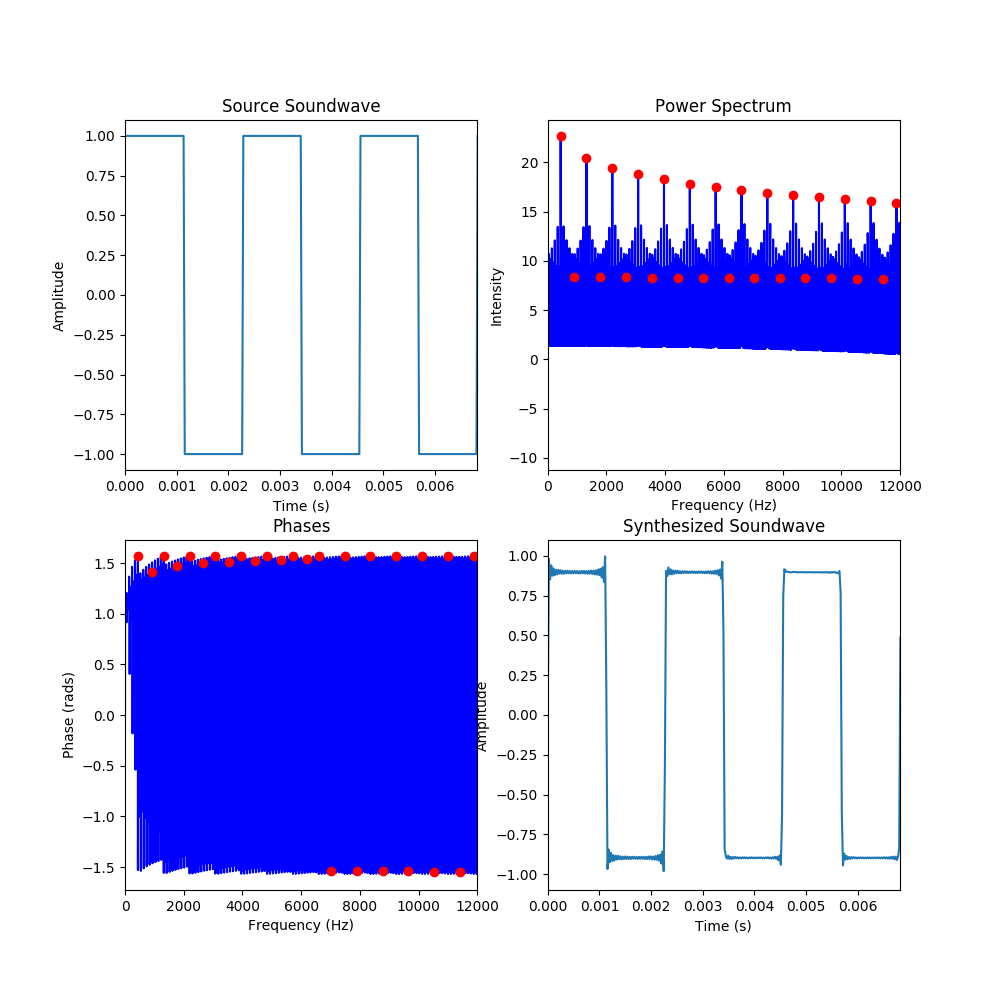

In [138]:
selected_instrument = 'square_wave'
student_name = 'test'
full_analysis(selected_instrument, student_name)

<IPython.core.display.Javascript object>


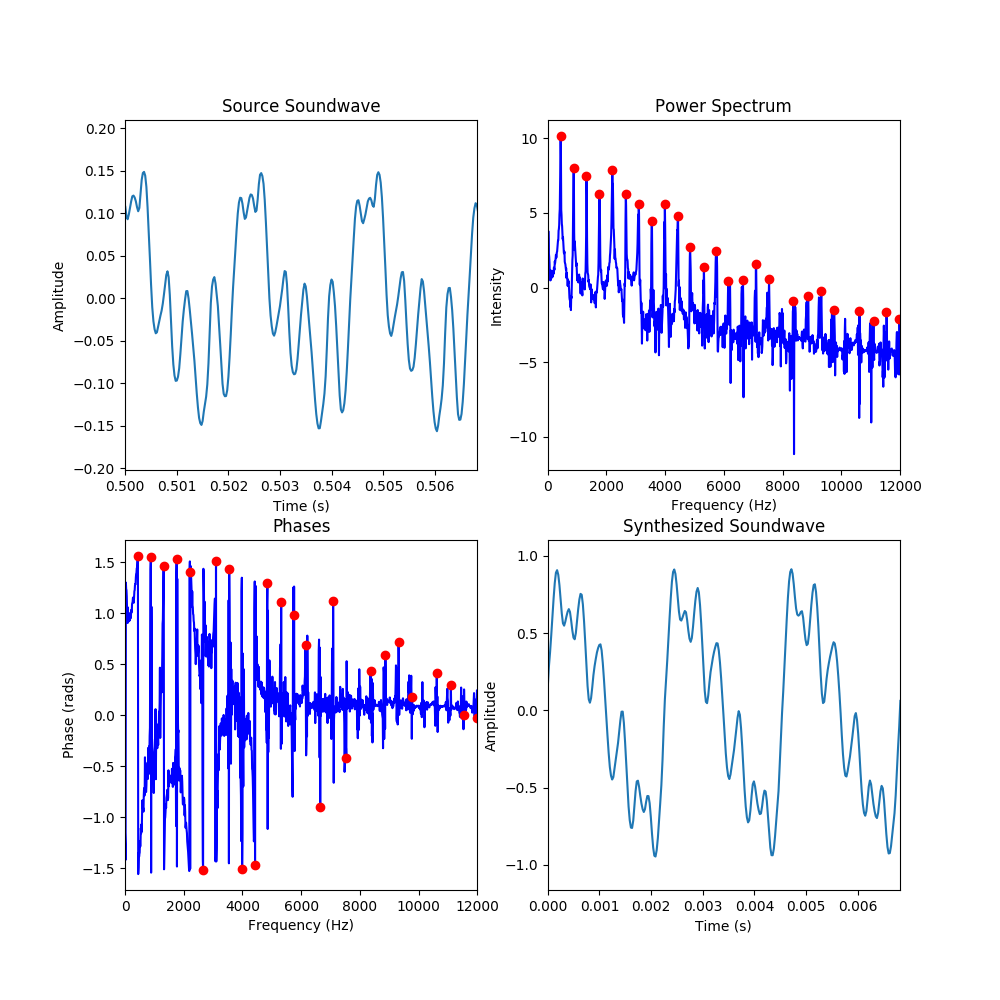

In [139]:
selected_instrument = 'violin'
student_name = 'ttest'
full_analysis(selected_instrument, student_name, t0=0.5, t1=0.6)

<IPython.core.display.Javascript object>


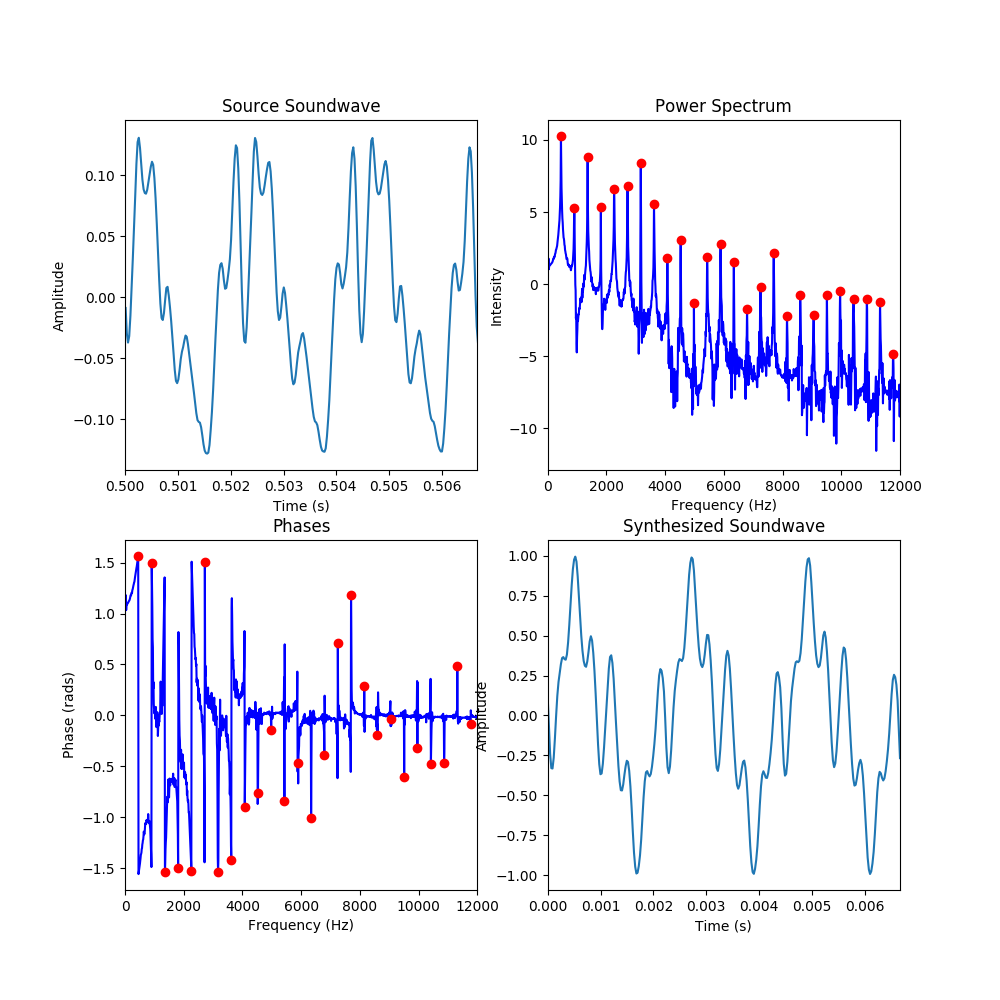

In [142]:
selected_instrument = 'sax'
student_name = 'ttest'
full_analysis(selected_instrument, student_name, t0=0.5, t1=0.6 )